## A Gentle Introduction to Causal Inference

### CDCS

Welcome to the second python tutorial for the Gentle Introduction to Causal Inference course with the CDCS. In this script you will use your python skills to employ causal inference in practice. For this we will be using the 'palmer penguins' dataset. More information can be found about this data set here: https://allisonhorst.github.io/palmerpenguins/index.html. For time purposes we will use the csv version of this file from the github.

In this exercise, we will explore whether **species type (Adelie vs. other species) has an effect on flipper length** in penguins. The idea is to estimate whether belonging to the **Adelie species** causally influences flipper length, while accounting for potential confounding factors such as **bill length, bill depth, body mass, and other morphological characteristics**.

This mirrors real-world studies in **ecology and social sciences**, where researchers investigate whether an exposure (e.g., policy, education, or a biological factor) has a causal impact on an outcome. However, in observational data, individuals (or penguins in this case!) are **not randomly assigned** to species groups, which means **confounding** may be present.

### Exercise 0
We're going to go ahead and load in the same data we used last week. Additionally we will import a range of packages. There is a comment next to each one. Briefly discuss what we use each package for in your group.

In [ ]:
import pandas as pd                                     # IMPORT FOR: Data Handling
import numpy as np                                      # IMPORT FOR: Numerical Calculations          
import seaborn as sns                                   # IMPORT FOR: Data Visualisation
import matplotlib.pyplot as plt                         # IMPORT FOR: Data Visualisation
from sklearn.linear_model import LogisticRegression     # IMPORT FOR: Propensity Scoring
from sklearn.utils import resample                      # IMPORT FOR: Matching
import statsmodels.api as sm                            # IMPORT FOR: Estimation
from statsmodels.formula.api import ols                 # IMPORT FOR: Estimation

In [2]:
# Load dataset and drop missing values for simplicity
penguins = pd.read_csv("palmer_penguins.csv")
penguins = penguins.dropna()

### Exercise 1
For being able to conduct our propensity scores we need a binary variable 'treatment' to work with. This simply means our independent variable (exposure) needs to be binary. Go ahead and create a species binary variable which encodes the Adelie species as 1 and Chinstrap/Gentoo as 0.

In [3]:
penguins['treated'] = penguins['species'].apply(lambda x: 1 if x == 'Adelie' else 0)

### Exercise 2
We're now going to estimate our propensity scores. Select the following as covariates: 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', and 'body_mass_g'. Then run the logistic regression below to estimate our propensity scores.

In [4]:
covariates = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
logit = LogisticRegression()
logit.fit(penguins[covariates], penguins['treated'])
penguins['propensity_score'] = logit.predict_proba(penguins[covariates])[:, 1]

### Exercise 3
When we estimate propesity scoring it is useful for us to visualise how these scores are distributed throughout our dataset. Lets create a plot to help us to do this. Run the code below and discuss in below it what you see. In particular answer:

i. Can we anticipate from this how much data we may need to remove?

ii. Is there anything in between the two groups which may help us decide?

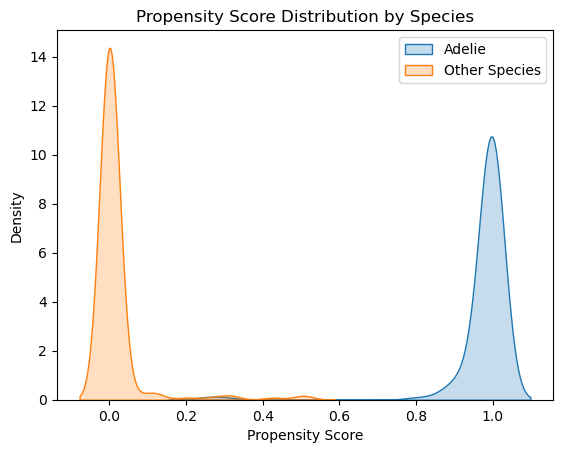

In [5]:
sns.kdeplot(penguins[penguins['treated'] == 1]['propensity_score'], label='Adelie', fill=True)
sns.kdeplot(penguins[penguins['treated'] == 0]['propensity_score'], label='Other Species', fill=True)
plt.title("Propensity Score Distribution by Species")
plt.xlabel("Propensity Score")
plt.legend()
plt.show()

i. The two barely overlap and this suggests that many don't have a counterpart and so will struggle to be matched.

ii. There is only a small overlap region which suggests we might be better to consider IPTW.

### Exercise 4
Now we need to perform some sort of matching. We want to do this based on the propensity scores. We can use **nearest-neighbour matching** based on propensity scores. We should then assess balance before and after matching.

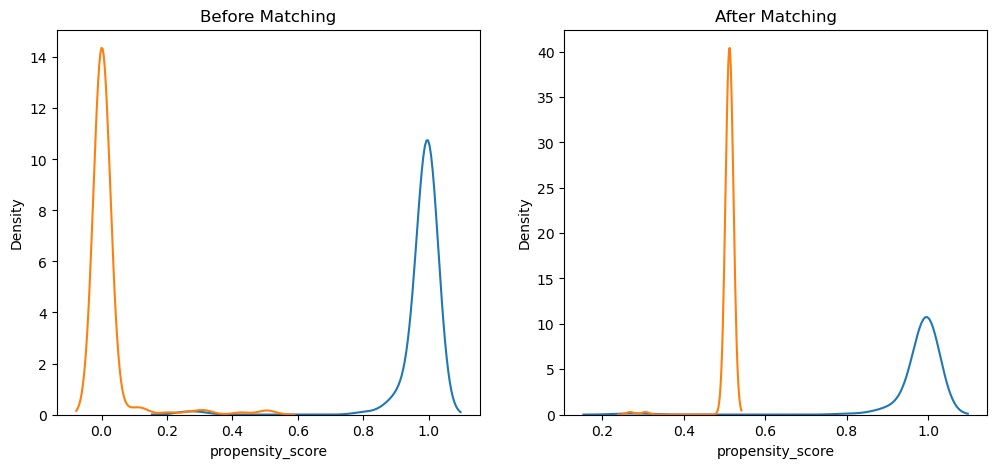

In [15]:
treated = penguins[penguins['treated'] == 1]
control = penguins[penguins['treated'] == 0]

treated = treated.sort_values("propensity_score")
control = control.sort_values("propensity_score")

matched_control = control.iloc[np.argmin(np.abs(control['propensity_score'].values[:, None] - treated['propensity_score'].values), axis=0)]
matched_data = pd.concat([treated, matched_control])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(penguins[penguins['treated'] == 1]['propensity_score'], label='Adelie', ax=ax[0])
sns.kdeplot(penguins[penguins['treated'] == 0]['propensity_score'], label='Other Species', ax=ax[0])
ax[0].set_title('Before Matching')

sns.kdeplot(matched_data[matched_data['treated'] == 1]['propensity_score'], label='Adelie', ax=ax[1])
sns.kdeplot(matched_data[matched_data['treated'] == 0]['propensity_score'], label='Other Species', ax=ax[1])
ax[1].set_title('After Matching')
plt.show()

The two curves are now somewhat seperated, but the density has increased to a sharp peak at one point. This suggests that the matching has remove a large chunk of the control group. However there is still an inbalance as most of the control is 0.4-0.5, whilst the treated is 1.0.

### Exercise 5

Finally, even if it isn't looking too promising lets still retrieve an estimate using the matched data. Comment on this and the confidence interval that we see.

In [16]:
matched_model = sm.OLS(matched_data['flipper_length_mm'], sm.add_constant(matched_data['treated'])).fit()
matched_effect = matched_model.params.iloc[1]
matched_ci = matched_model.conf_int().loc['treated']
print(f"Matched Treatment Effect Estimate: {matched_effect:.4f} ({matched_ci[0]:.4f}, {matched_ci[1]:.4f})")

Matched Treatment Effect Estimate: 8.8699 (7.7569, 9.9828)


### Exercise 6
Now lets try to compute **IPTW weights** based on propensity scores and reweight the data to create a pseudo-randomised sample. Once again comment on the plot you seem, what can we tell about the potential success of our IPTW from the graph?

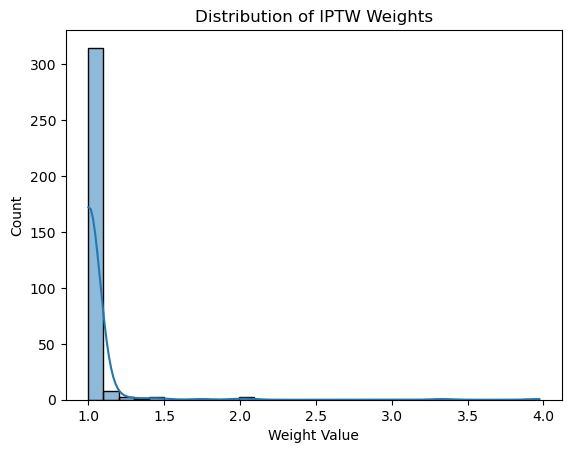

In [8]:
penguins['iptw_weight'] = np.where(penguins['treated'] == 1, 1 / penguins['propensity_score'], 1 / (1 - penguins['propensity_score']))
sns.histplot(penguins['iptw_weight'], bins=30, kde=True)
plt.title("Distribution of IPTW Weights")
plt.xlabel("Weight Value")
plt.show()

Here we see that most of the weights are relatively small, but there are a few which are weighted extemely high compared to the others.

### Exercise 7
Our final task is to use the statsmodels weighted method to use IPTW to estimate the causal effect of being an Adelie penguin on flipper length. Run this and comment on the difference between the IPTW based estimate and the matched based estimate...something very interesting has occured and highlights the wider issue of confounding...

In [9]:
iptw_model = sm.WLS(
    penguins['flipper_length_mm'],
    sm.add_constant(penguins['treated']),
    weights=penguins['iptw_weight']
).fit()

iptw_effect = iptw_model.params.iloc[1]
iptw_ci = iptw_model.conf_int().loc['treated']
print(f"IPTW Treatment Effect Estimate: {iptw_effect:.4f} ({iptw_ci[0]:.4f}, {iptw_ci[1]:.4f})")

IPTW Treatment Effect Estimate: -18.5248 (-20.7968, -16.2528)
